In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print (f"Train data shape: {train.shape}")
print (f"Test data shape: {test.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# MSSubClass

In [6]:
np.sort(train.MSSubClass.unique())

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190])

In [7]:
train.MSSubClass.value_counts(sort=True, dropna=False)

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [8]:
# Note: "150 - 1-1/2 STORY PUD - ALL AGES" is missing

In [9]:
new = [20,60,120,160]
old = [30,70]
def older_newer(x):
    if x in new:
        return 2
    elif x in old:
        return 1
    else: return 0

train['MSSubClass_OLDNEW'] = train.MSSubClass.apply(older_newer)
test['MSSubClass_OLDNEW'] = test.MSSubClass.apply(older_newer)

In [10]:
story1 = [20,30,40]
story15 = [45,50,150]
story2 = [60,70,160]
story25 = [75]

def story(x):
    if x in story1:
        return 4
    elif x in story15:
        return 3
    elif x in story2:
        return 2
    elif x in story25:
        return 1
    else: return 0

train['MSSubClass_STORY'] = train.MSSubClass.apply(story)
test['MSSubClass_STORY'] = test.MSSubClass.apply(story)

In [11]:
all_styles = [20,90,190]
all_ages = [40,45,50,75,90,150,190]
def all_styles_ages(x):
    if x in all_styles:
        return 2
    elif x in all_ages:
        return 1
    else: return 0

train['MSSubClass_STYLES_AGES'] = train.MSSubClass.apply(all_styles_ages)
test['MSSubClass_STYLES_AGES'] = test.MSSubClass.apply(all_styles_ages)

In [12]:
pud = [120,150,160,180]
train['MSSubClass_PUD'] = train.MSSubClass.apply(lambda x: 1 if x in pud else 0)
test['MSSubClass_PUD'] = test.MSSubClass.apply(lambda x: 1 if x in pud else 0)

In [13]:
attic_finished = [50]
attic_unfinished = [45]
attic_wfinished = [40]

def attic(x):
    if x in attic_finished:
        return 3
    elif x in attic_unfinished:
        return 2
    elif x in attic_wfinished:
        return 1
    else: return 0

train['MSSubClass_ATTIC'] = train.MSSubClass.apply(attic)
test['MSSubClass_ATTIC'] = test.MSSubClass.apply(attic)

In [14]:
# TODO: Study these features
split_multilevel = [80]
split_foyer = [85]
duplex = [90]
multilevel = [180]
family_conversion = [190]

def other(x):
    if x in split_multilevel:
        return 5
    elif x in split_foyer:
        return 4
    elif x in duplex:
        return 3
    elif x in multilevel:
        return 2
    elif x in family_conversion:
        return 1
    else: return 0

train['MSSubClass_OTHER'] = train.MSSubClass.apply(other)
test['MSSubClass_OTHER'] = test.MSSubClass.apply(other)

In [15]:
train.drop("MSSubClass",inplace=True, axis=1)
version = 'MSSubClass-dropped'

# MSZoning

In [17]:
np.sort(train.MSZoning.unique())

array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [18]:
train.MSZoning.value_counts(sort=True, dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [19]:
test.MSZoning.value_counts(sort=True, dropna=False)

RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: MSZoning, dtype: int64

In [20]:
quality_pivot = train.pivot_table(index='MSZoning',
                  values='SalePrice', aggfunc=np.median)

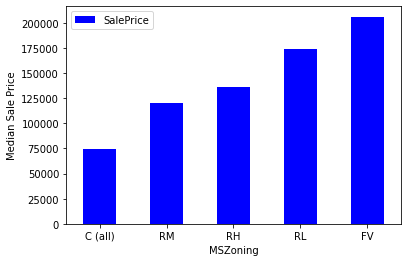

In [21]:
quality_pivot.sort_values('SalePrice').plot(kind='bar', color='blue')
plt.xlabel('MSZoning')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [22]:
featler = ['RH','RL','RP','RM',]
train['MSZoning_Residential'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_Residential'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [23]:
def density(x):
    if x in ['RH']:
        return 1
    elif  x in ['RM']:
        return 2
    elif x in ['RL']:
        return 3
    elif x in ['RP']:
        return 4
    else: return 0

train['MSZoning_Density'] = train.MSZoning.apply(density)
test['MSZoning_Density'] = test.MSZoning.apply(density)

In [24]:
featler = ['FV']
train['MSZoning_FloatingVillage'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_FloatingVillage'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [25]:
train.drop("MSZoning",inplace=True, axis=1)

# LotFrontage

In [26]:
np.sort(train.LotFrontage.unique())

array([ 21.,  24.,  30.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 114., 115., 116., 118.,
       120., 121., 122., 124., 128., 129., 130., 134., 137., 138., 140.,
       141., 144., 149., 150., 152., 153., 160., 168., 174., 182., 313.,
        nan])

In [27]:
train.LotFrontage.value_counts(sort=True, dropna=False)

NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
111.0      1
141.0      1
112.0      1
152.0      1
144.0      1
Name: LotFrontage, Length: 111, dtype: int64

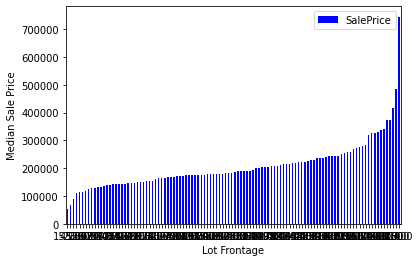

In [28]:
quality_pivot = train.pivot_table(index='LotFrontage',
                  values='SalePrice', aggfunc=np.median)
quality_pivot.sort_values('SalePrice').plot(kind='bar', color='blue')
plt.xlabel('Lot Frontage')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

### Handling Null Value

In [29]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageQual,81
GarageFinish,81


### Replace missing data

In [30]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

### Split data

In [31]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

# Modeling

In [33]:
df_result = pd.DataFrame(columns=['Method','RMSE','GridParams'])

In [34]:
def rmse(df, model):
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return df.append({'Method':model.__class__.__name__, 'RMSE':rmse}, ignore_index=True)

def grid_rmse(df, grid):
    rmse = np.sqrt(np.sqrt(np.abs(grid.best_score_)))
    if hasattr(grid, 'best_params_'):
        params = grid.best_params_
    return df.append({'Method':"{} Grid".format(grid.estimator.__class__.__name__), 'RMSE':rmse, 'GridParams':params}, ignore_index=True)

## Linear Regression

In [35]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
#print ("Root Square is: \n", lr.score(X_test, y_test))
#print ('RMSE is: \n', mean_squared_error(y_test, predictions, squared=False))

# Add to the main array
df_result = rmse(df_result, lr)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN


## Ridge Regression

### Grid Search

In [36]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
ridge_model = linear_model.Ridge()
grid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])})

In [37]:
grid.best_estimator_

Ridge()

In [38]:
grid.best_params_

{'alpha': 1.0}

In [39]:
print(grid.best_estimator_)
df_result = grid_rmse(df_result, grid)

Ridge()


### Simple

In [40]:
ridge_model = linear_model.Ridge(alpha=grid.best_estimator_.alpha)
ridge_model.fit(X_train, y_train)
preds_ridge = ridge_model.predict(X_test)
print(ridge_model.score(X_test, y_test))
print("Ridge Regression RMSE: {}".format(mean_squared_error(y_test, preds_ridge, squared=False)))
df_result = rmse(df_result, ridge_model)
df_result

0.8754560922715314
Ridge Regression RMSE: 0.1456921084946003


,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN


## Lasso

In [41]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
lasso_model = linear_model.Lasso()
grid_lasso = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=alphas))
grid_lasso.fit(X_train, y_train)
df_result = grid_rmse(df_result, grid_lasso)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}


## Random Forest

### Grid Search

In [42]:
# Search Ranfom Forest Grid
do_rf_grid = False

In [43]:
if do_rf_grid:
    rf_params = {'n_estimators': range(150, 600, 10), 'max_depth': range(3, 15, 1),'min_samples_leaf':[0.04,0.06,0.08,0.1,0.12,0.14], 'max_features':[0.2,0.4,0.6,0.8]}

    grid_rf = GridSearchCV(estimator = RandomForestRegressor(),
                         param_grid = rf_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    df_result = grid_rmse(df_result, grid_rf)
    print('Best parameters found for rf: ', grid_rf.best_params_)
    print('Lowerst RMSE found for rf: ', np.sqrt(np.sqrt(np.abs(grid_rf.best_score_))))

### Simple

In [44]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf=0.12, random_state=123)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest RMSE: {} ".format(mean_squared_error(y_test, rf_pred,squared=False)))
df_result = rmse(df_result, rf)
df_result

Random Forest RMSE: 0.24451083147497246 


,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN


## Bayesian Regression

In [45]:
bayesridge_model = linear_model.BayesianRidge()
bayesridge_model.fit(X_train, y_train)
df_result = rmse(df_result, bayesridge_model)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN


## Logistic Regression

In [46]:
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#df_result = rmse(df_result, clf)
#df_result

## CatBoost Regressor

In [47]:
cbr = CatBoostRegressor().fit(X_train,y_train)
df_result = rmse(df_result, cbr)
df_result

Learning rate set to 0.038876
0:	learn: 0.3836681	total: 47.5ms	remaining: 47.5s
1:	learn: 0.3749838	total: 48.8ms	remaining: 24.3s
2:	learn: 0.3666964	total: 49.9ms	remaining: 16.6s
3:	learn: 0.3584254	total: 56.1ms	remaining: 14s
4:	learn: 0.3498792	total: 57ms	remaining: 11.3s
5:	learn: 0.3419395	total: 57.8ms	remaining: 9.58s
6:	learn: 0.3341854	total: 58.7ms	remaining: 8.32s
7:	learn: 0.3266117	total: 59.6ms	remaining: 7.39s
8:	learn: 0.3199417	total: 60.5ms	remaining: 6.67s
9:	learn: 0.3132094	total: 61.4ms	remaining: 6.08s
10:	learn: 0.3061630	total: 62.3ms	remaining: 5.6s
11:	learn: 0.2997044	total: 63.2ms	remaining: 5.2s
12:	learn: 0.2934005	total: 64ms	remaining: 4.86s
13:	learn: 0.2870873	total: 64.8ms	remaining: 4.56s
14:	learn: 0.2810072	total: 65.7ms	remaining: 4.31s
15:	learn: 0.2754342	total: 66.6ms	remaining: 4.09s
16:	learn: 0.2699907	total: 67.4ms	remaining: 3.9s
17:	learn: 0.2651260	total: 68.3ms	remaining: 3.72s
18:	learn: 0.2604828	total: 69.1ms	remaining: 3.57s
1

252:	learn: 0.0895995	total: 271ms	remaining: 799ms
253:	learn: 0.0894419	total: 272ms	remaining: 798ms
254:	learn: 0.0891991	total: 273ms	remaining: 796ms
255:	learn: 0.0891661	total: 273ms	remaining: 794ms
256:	learn: 0.0889577	total: 274ms	remaining: 793ms
257:	learn: 0.0888070	total: 275ms	remaining: 792ms
258:	learn: 0.0887446	total: 276ms	remaining: 790ms
259:	learn: 0.0886223	total: 277ms	remaining: 788ms
260:	learn: 0.0884633	total: 278ms	remaining: 787ms
261:	learn: 0.0882599	total: 279ms	remaining: 785ms
262:	learn: 0.0880551	total: 280ms	remaining: 784ms
263:	learn: 0.0878739	total: 281ms	remaining: 782ms
264:	learn: 0.0876389	total: 281ms	remaining: 780ms
265:	learn: 0.0874357	total: 282ms	remaining: 779ms
266:	learn: 0.0874102	total: 283ms	remaining: 777ms
267:	learn: 0.0872246	total: 284ms	remaining: 776ms
268:	learn: 0.0871982	total: 285ms	remaining: 774ms
269:	learn: 0.0870085	total: 286ms	remaining: 772ms
270:	learn: 0.0868315	total: 287ms	remaining: 771ms
271:	learn: 

464:	learn: 0.0645987	total: 463ms	remaining: 533ms
465:	learn: 0.0644255	total: 464ms	remaining: 532ms
466:	learn: 0.0643492	total: 465ms	remaining: 531ms
467:	learn: 0.0642758	total: 466ms	remaining: 530ms
468:	learn: 0.0641202	total: 467ms	remaining: 529ms
469:	learn: 0.0640539	total: 468ms	remaining: 528ms
470:	learn: 0.0639662	total: 469ms	remaining: 527ms
471:	learn: 0.0638495	total: 470ms	remaining: 526ms
472:	learn: 0.0637509	total: 471ms	remaining: 524ms
473:	learn: 0.0636547	total: 472ms	remaining: 523ms
474:	learn: 0.0635808	total: 472ms	remaining: 522ms
475:	learn: 0.0634304	total: 473ms	remaining: 521ms
476:	learn: 0.0633478	total: 474ms	remaining: 520ms
477:	learn: 0.0632345	total: 475ms	remaining: 519ms
478:	learn: 0.0631534	total: 476ms	remaining: 518ms
479:	learn: 0.0630653	total: 477ms	remaining: 517ms
480:	learn: 0.0629419	total: 478ms	remaining: 516ms
481:	learn: 0.0628387	total: 479ms	remaining: 515ms
482:	learn: 0.0627217	total: 480ms	remaining: 513ms
483:	learn: 

676:	learn: 0.0486855	total: 655ms	remaining: 313ms
677:	learn: 0.0486792	total: 656ms	remaining: 312ms
678:	learn: 0.0485902	total: 657ms	remaining: 311ms
679:	learn: 0.0485049	total: 658ms	remaining: 310ms
680:	learn: 0.0484661	total: 659ms	remaining: 309ms
681:	learn: 0.0484051	total: 660ms	remaining: 308ms
682:	learn: 0.0483308	total: 661ms	remaining: 307ms
683:	learn: 0.0482703	total: 662ms	remaining: 306ms
684:	learn: 0.0482063	total: 663ms	remaining: 305ms
685:	learn: 0.0481108	total: 664ms	remaining: 304ms
686:	learn: 0.0480515	total: 664ms	remaining: 303ms
687:	learn: 0.0479848	total: 665ms	remaining: 302ms
688:	learn: 0.0479188	total: 666ms	remaining: 301ms
689:	learn: 0.0478533	total: 667ms	remaining: 300ms
690:	learn: 0.0477931	total: 668ms	remaining: 299ms
691:	learn: 0.0477078	total: 669ms	remaining: 298ms
692:	learn: 0.0477049	total: 670ms	remaining: 297ms
693:	learn: 0.0476237	total: 671ms	remaining: 296ms
694:	learn: 0.0475466	total: 671ms	remaining: 295ms
695:	learn: 

891:	learn: 0.0377022	total: 847ms	remaining: 103ms
892:	learn: 0.0376990	total: 848ms	remaining: 102ms
893:	learn: 0.0376625	total: 849ms	remaining: 101ms
894:	learn: 0.0375983	total: 850ms	remaining: 99.7ms
895:	learn: 0.0375498	total: 851ms	remaining: 98.8ms
896:	learn: 0.0374921	total: 852ms	remaining: 97.8ms
897:	learn: 0.0374358	total: 853ms	remaining: 96.8ms
898:	learn: 0.0373632	total: 853ms	remaining: 95.9ms
899:	learn: 0.0372946	total: 854ms	remaining: 94.9ms
900:	learn: 0.0372456	total: 855ms	remaining: 94ms
901:	learn: 0.0371725	total: 856ms	remaining: 93ms
902:	learn: 0.0371320	total: 857ms	remaining: 92ms
903:	learn: 0.0370961	total: 858ms	remaining: 91.1ms
904:	learn: 0.0370466	total: 859ms	remaining: 90.1ms
905:	learn: 0.0370134	total: 859ms	remaining: 89.2ms
906:	learn: 0.0369569	total: 860ms	remaining: 88.2ms
907:	learn: 0.0369541	total: 861ms	remaining: 87.3ms
908:	learn: 0.0368927	total: 862ms	remaining: 86.3ms
909:	learn: 0.0368891	total: 863ms	remaining: 85.4ms
91

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN
6,CatBoostRegressor,0.134105,NaN


## XGBoost

### Grid Search

In [48]:
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9], 'n_estimators': [200], 'subsample':[0.3,0.5,0.9]}
grid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'), param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_xgb.fit(X_train,y_train)
df_result = grid_rmse(df_result, grid_xgb)
df_result

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN
6,CatBoostRegressor,0.134105,NaN
7,XGBRegressor Grid,0.368344,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."


In [49]:
xgbm = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.01,
                max_depth=5, alpha = 10, n_estimators = 1000)
xgbm.fit(X_train,y_train)
df_result = rmse(df_result, xgbm)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN
6,CatBoostRegressor,0.134105,NaN
7,XGBRegressor Grid,0.368344,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.175500,NaN


## Gradient Boost Regressor

In [50]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

kfold = KFold(n_splits=num_folds)
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid_gb.fit(X=rescaledX, y=y_train)

df_result = grid_rmse(df_result, grid_gb)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN
6,CatBoostRegressor,0.134105,NaN
7,XGBRegressor Grid,0.368344,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.175500,NaN
9,GradientBoostingRegressor Grid,0.369765,{'n_estimators': 200}


## Extra Trees Regressor

In [51]:
etr_model = ExtraTreesRegressor(n_estimators=80)
etr_model.fit(X=X_train, y=y_train)
df_result = rmse(df_result, etr_model)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.144645,NaN
1,Ridge Grid,0.939380,{'alpha': 1.0}
2,Ridge,0.145692,NaN
3,Lasso Grid,0.938850,{'alpha': 0.0001}
4,RandomForestRegressor,0.244511,NaN
5,BayesianRidge,0.148015,NaN
6,CatBoostRegressor,0.134105,NaN
7,XGBRegressor Grid,0.368344,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.175500,NaN
9,GradientBoostingRegressor Grid,0.369765,{'n_estimators': 200}


# Results

In [52]:
df_result.sort_values(by='RMSE')

,Method,RMSE,GridParams
6,CatBoostRegressor,0.134105,NaN
0,LinearRegression,0.144645,NaN
2,Ridge,0.145692,NaN
5,BayesianRidge,0.148015,NaN
10,ExtraTreesRegressor,0.148579,NaN
8,XGBRegressor,0.175500,NaN
4,RandomForestRegressor,0.244511,NaN
7,XGBRegressor Grid,0.368344,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
9,GradientBoostingRegressor Grid,0.369765,{'n_estimators': 200}
3,Lasso Grid,0.938850,{'alpha': 0.0001}


In [53]:
print(df_result['RMSE'].to_string(index=False))

0.144645
0.939380
0.145692
0.938850
0.244511
0.148015
0.134105
0.368344
0.175500
0.369765
0.148579
